In [2]:
############################
## Load required packages ##
############################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from covid19model.models.models import COVID19_SEIQRD_spatial_stratified_rescaling
from covid19model.models.utils import initialize_COVID19_SEIQRD_stratified_vacc

# Import time-dependent parameter functions for resp. P, Nc, alpha, N_vacc, season_factor
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, \
                                                          make_contact_matrix_function, \
                                                          make_VOC_function, \
                                                          make_vaccination_function, \
                                                          make_seasonality_function

# Import packages containing functions to load in data used in the model and the time-dependent parameter functions
from covid19model.data import mobility, sciensano, model_parameters, VOC

In [3]:
#########################
## Load necessary data ##
#########################

# Population size, interaction matrices and the model parameters
initN, Nc_dict, params, CORE_samples_dict = model_parameters.get_COVID19_SEIQRD_parameters(spatial='prov')

# Google Mobility data (for social contact Nc)
df_google = mobility.get_google_mobility_data(update=False, provincial=True)

# Load and format mobility dataframe (for mobility place)
proximus_mobility_data = mobility.get_proximus_mobility_data('prov')

# Variants of concern
VOCs = ['WT', 'abc', 'delta']
VOC_logistic_growth_parameters, VOC_params = model_parameters.get_COVID19_SEIQRD_VOC_parameters(initN, params['h'], VOCs=VOCs)
params.update(VOC_params)

# Load and format local vaccination data, which is also under the sciensano object
public_spatial_vaccination_data = sciensano.get_public_spatial_vaccination_data(update=False,agg='prov')

In [4]:
# Delete parameters that are superfluous for the new approach

superfluous_params = ['f_immune_escape', 'e_s', 'e_h', 'e_i', 'doses', 'd_vacc', 'N_vacc', 'daily_doses', 'delay_immunity', 'vacc_order', 'stop_idx', 'refusal', 'initN', 'default_mobility', 'onset_days']
for key in superfluous_params:
    if key in params:
        params.pop(key)
        
# Add new parameters (these will be time-dependent soon)
params['E_susc'] = np.ones(11)*1.1
params['E_inf'] = np.ones(11)*1.2
params['E_hosp'] = np.ones(11)*1.3

In [5]:
##################################################
## Construct time-dependent parameter functions ##
##################################################

# Time-dependent social contact matrix over all policies, updating Nc
policy_function = make_contact_matrix_function(df_google, Nc_dict).policies_all_spatial
policy_function_work = make_contact_matrix_function(df_google, Nc_dict).policies_all_work_only

# Time-dependent mobility function, updating P (place)
mobility_function = \
    make_mobility_update_function(proximus_mobility_data).mobility_wrapper_func

# Time-dependent VOC function, updating alpha
VOC_function = make_VOC_function(VOC_logistic_growth_parameters)

# Time-dependent vaccination-induced rescaling parameter functions, updating E_susc^g, E_inf^g, E_hosp^g
# E_susc_function, E_inf_function, E_hosp_function = make_vaccination_rescaling_functions(public_spatial_vaccination_data,
#                                                                                       VOC_function, VOC_params)

# Time-dependent seasonality function, updating season_factor
seasonality_function = make_seasonality_function()

In [6]:
####################
## Initial states ##
####################

import pickle
data_path = "../../data/"

# Get correct initial condition
samples_path = data_path + 'interim/model_parameters/COVID19_SEIQRD/initial_conditions/prov/'

with open(samples_path+'initial_states-COVID19_SEIQRD_spatial.pickle', 'rb') as handle:
    load = pickle.load(handle)
    initial_states = load['2020-03-17']

In [ ]:
##########################
## Initialize the model ##
##########################

# Initiate model with initial states, defined parameters, and proper time dependent functions
model = COVID19_SEIQRD_spatial_stratified_rescaling(initial_states, params, spatial='prov',
                        time_dependent_parameters={'Nc' : policy_function,
                                                'Nc_work' : policy_function_work,
                                                'place' : mobility_function,
                                                'beta_R' : seasonality_function,
                                                'beta_U': seasonality_function,
                                                'beta_M': seasonality_function})

In [ ]:
###################
## Run the model ##
###################
end_visualization = '2022-06-01'
start_calibration = '2020-03-18'
warmup = 0
out = model.sim(end_visualization,start_date=start_calibration,warmup=warmup)

In [204]:
vacc_data = sciensano.get_public_spatial_vaccination_data(update=False,agg='prov')

### VALUES FOR WILD TYPE
# test values
onset_days_WT = dict({'E_susc' : {'first' : 21, 'full' : 21, 'booster' : 21},
               'E_inf' : {'first' : 14, 'full' : 14, 'booster' : 14},
               'E_hosp' : {'first' : 21, 'full' : 21, 'booster' : 21}})

# E_init is the value of the previous waned vaccine
E_init_WT = dict({'E_susc' : {'first' : 1, 'full' : 0.8, 'booster' : 0.4},
               'E_inf' : {'first' : 1, 'full' : 0.5, 'booster' : 0.6},
               'E_hosp' : {'first' : 1, 'full' : 0.4, 'booster' : 0.5}})
E_best_WT = dict({'E_susc' : {'first' : 0.4, 'full' : 0.3, 'booster' : 0.3},
               'E_inf' : {'first' : 0.5, 'full' : 0.4, 'booster' : 0.4},
               'E_hosp' : {'first' : 0.2, 'full' : 0.1, 'booster' : 0.1}})
E_waned_WT = dict({'E_susc' : {'first' : 0.4, 'full' : 0.5, 'booster' : 0.3},
               'E_inf' : {'first' : 0.5, 'full' : 0.6, 'booster' : 0.4},
               'E_hosp' : {'first' : 0.2, 'full' : 0.2, 'booster' : 0.1}})



def smooth_vacc_stage_fraction(vacc_data, initN):
    """Desired output: DataFrame per week with fractions of vaccination stage per age class and per province NIS
    
    TO DO: resample this dataframe to daily data.
    
    Input
    -----
    
    vacc_data: pd.DataFrame
        Output of make_vaccination_function(vacc_data['INCIDENCE']).df with the default age intervals
    initN: pd.DataFrame
        Output of model_parameters.get_COVID19_SEIQRD_parameters(spatial='prov')
        
    Output
    ------
    
    df_new : pd.DataFrame
        MultiIndex DataFrame with indices date (weekly), NIS, age, dose.
        Values are 'fraction', which always sum to unity (a subject is in only one of four vaccination stages)
    
    """
    
    # set initN column names to pd.Interval objects
    intervals = pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')
    intervals_str = np.array(['[0, 12)', '[12, 18)', '[18, 25)', '[25, 35)', '[35, 45)', '[45, 55)', '[55, 65)', '[65, 75)', '[75, 85)', '[85, 120)'])
    intervals_dict = dict({intervals_str[i] : intervals[i] for i in range(len(intervals))})
    initN = initN.rename(columns=intervals_dict)
    initN = initN.unstack().reset_index().rename(columns={0 : 'population'})
    
    # Name nameless column to 'INCIDENCE' and add 'CUMULATIVE' column
    df_new = pd.DataFrame(vacc_data).rename(columns={0 : 'INCIDENCE'})
    df_new['CUMULATIVE'] = df_new.groupby(level=[1,2,3]).cumsum()
    
    # Make cumulative fractions by comparing with relevant initN
    df_new = pd.DataFrame(df_new).reset_index()
    df_new = df_new.merge(initN, left_on=['NIS', 'age'], right_on=['NIS', 'age_class'])
    df_new['fraction'] = df_new['CUMULATIVE'] / df_new['population']
    
    # Start redefining vaccination stage fractions
    df_new = df_new.set_index('date') # make sure we don't get NaN values because of mismatching indices
    df_new_copy = df_new.copy()

    # first-only: dose A (first) - dose B (second)
    df_new.loc[df_new['dose']=='B','fraction'] = (df_new_copy.loc[df_new_copy['dose']=='A','fraction'] \
        - df_new_copy.loc[df_new_copy['dose']=='B','fraction']).clip(lower=0, upper=1)

    # full: dose B (second) + dose C (Jansen) - dose E (booster)
    df_new.loc[df_new['dose']=='C','fraction'] = (df_new_copy.loc[df_new_copy['dose']=='B','fraction'] \
        + df_new_copy.loc[df_new_copy['dose']=='C','fraction'] - df_new_copy.loc[df_new_copy['dose']=='E','fraction']).clip(lower=0, upper=1)
    
    # booster: clip between 0 and 1. This is currently the latest stage
    df_new.loc[df_new['dose']=='E','fraction'] = df_new_copy.loc[df_new_copy['dose']=='E', 'fraction'].clip(lower=0, upper=1)
    
    # none. Rest category. Make sure all exclusive categories adds up to 1.
    df_new.loc[df_new['dose']=='A','fraction'] = 1 - df_new.loc[df_new['dose']=='B','fraction'] \
        - df_new.loc[df_new['dose']=='C','fraction'] - df_new.loc[df_new['dose']=='E','fraction']
    
    ### Make sure all incidence and cumulative data are in the right columns
    # full = second + janssen
    df_new.loc[df_new['dose']=='C', 'INCIDENCE'] += df_new.loc[df_new['dose']=='B', 'INCIDENCE']
    df_new.loc[df_new['dose']=='C', 'CUMULATIVE'] += df_new.loc[df_new['dose']=='B', 'CUMULATIVE']
    # first is moved from 'A' to 'B'
    df_new.loc[df_new['dose']=='B', 'INCIDENCE'] = df_new.loc[df_new['dose']=='A', 'INCIDENCE']
    df_new.loc[df_new['dose']=='B', 'CUMULATIVE'] = df_new.loc[df_new['dose']=='A', 'CUMULATIVE']
    # 'A' becomes the empty category and is nullified
    df_new.loc[df_new['dose']=='A', 'INCIDENCE'] = 0
    df_new.loc[df_new['dose']=='A', 'CUMULATIVE'] = 0
    
    
    # Initialise rescaling parameter columns
    for rescaling in ['E_susc', 'E_inf', 'E_hosp']:
        df_new[rescaling] = 0
        df_new.loc[df_new['dose']=='A', rescaling] = 1
    

    # Return to multiindex
    df_new = df_new.reset_index()
    df_new = df_new.drop(columns=['age_class', 'population'])
    df_new = df_new.set_index(['date','NIS', 'age', 'dose'])

    # rename indices to clearly understandable categories
    rename_indices = dict({'A' : 'none', 'B' : 'first', 'C' : 'full', 'E' : 'booster'})
    df_new = df_new.rename(index=rename_indices)
    
    # reset indices for next line of calculations
    df_new = df_new.reset_index()
    all_available_dates = df_new.date.unique()
    all_available_NIS = initN.NIS.unique()
    df_new = df_new.set_index(['date', 'dose']).sort_index()
    for rescaling in ['E_susc', 'E_inf', 'E_hosp']:
        for dose in ['first', 'full', 'booster']:
            # Calculate E values for this rescaling type and dose
            onset_days_temp = onset_days[rescaling][dose]
            E_init_temp = E_init[rescaling][dose]
            E_best_temp = E_best[rescaling][dose]
            E_waned_temp = E_waned[rescaling][dose]
            for date in all_available_dates:
                # run over all dates before this date
                for d in all_available_dates[all_available_dates<=date]:
                    # Calculate how many days there are in between
                    delta_days = pd.Timedelta(date - d).days
                    # Sum over previous days with a weight depending on incidence, dose type, and waning of vaccines
                    weight = waning_exp_delay(delta_days, onset_days_temp, E_init_temp, E_best_temp, E_waned_temp)
                    df_new.loc[(date, dose), rescaling] += df_new.loc[(d, dose),'INCIDENCE'].to_numpy() * weight
                # normalise over total number of vaccinated subjects up to that point
                df_new.loc[(date,dose), rescaling] /= df_new.loc[(date,dose), 'CUMULATIVE']
        # Get rid of all division-by-zero results
        df_new.loc[df_new[rescaling]==np.inf, rescaling] = 1
        df_new[rescaling].fillna(1, inplace=True)
        
    df_new = df_new.groupby(['date', 'NIS', 'age', 'dose']).first()

    # Calculate weighted average from fractions and current rescaling factor
    for date in all_available_dates:
        for NIS in all_available_NIS:
            print("working on NIS ", NIS)
            for interval in intervals:
                for rescaling in ['E_susc', 'E_inf', 'E_hosp']:
                    df_new.loc[(date,NIS,interval, 'weighted_sum'), rescaling] = \
                        (df_new.loc[(date,NIS,interval), rescaling] * \
                         df_new.loc[(date,NIS,interval), 'fraction']).sum()
    df_new = df_new.groupby(['date', 'NIS', 'age', 'dose']).first()
    
    return df_new

# uncomment if you have time
# df_inc = make_vaccination_function(vacc_data['INCIDENCE']).df
df_cum = df_inc.groupby(level=[1,2,3]).cumsum()

df_test = smooth_vacc_stage_fraction(df_inc, initN)#.loc[:,21000,pd.Interval(25, 35, closed='left'), 'full'].plot()

working on NIS  10000


C:\Users\mrollier\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2944: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


working on NIS  20001
working on NIS  20002
working on NIS  21000
working on NIS  30000
working on NIS  40000
working on NIS  50000
working on NIS  60000
working on NIS  70000
working on NIS  80000
working on NIS  90000
working on NIS  10000
working on NIS  20001
working on NIS  20002
working on NIS  21000
working on NIS  30000
working on NIS  40000
working on NIS  50000
working on NIS  60000
working on NIS  70000
working on NIS  80000
working on NIS  90000
working on NIS  10000
working on NIS  20001
working on NIS  20002
working on NIS  21000
working on NIS  30000
working on NIS  40000
working on NIS  50000
working on NIS  60000
working on NIS  70000
working on NIS  80000
working on NIS  90000
working on NIS  10000
working on NIS  20001
working on NIS  20002
working on NIS  21000
working on NIS  30000
working on NIS  40000
working on NIS  50000
working on NIS  60000
working on NIS  70000
working on NIS  80000
working on NIS  90000
working on NIS  10000
working on NIS  20001
working on

working on NIS  10000
working on NIS  20001
working on NIS  20002
working on NIS  21000
working on NIS  30000
working on NIS  40000
working on NIS  50000
working on NIS  60000
working on NIS  70000
working on NIS  80000
working on NIS  90000
working on NIS  10000
working on NIS  20001
working on NIS  20002
working on NIS  21000
working on NIS  30000
working on NIS  40000
working on NIS  50000
working on NIS  60000
working on NIS  70000
working on NIS  80000
working on NIS  90000
working on NIS  10000
working on NIS  20001
working on NIS  20002
working on NIS  21000
working on NIS  30000
working on NIS  40000
working on NIS  50000
working on NIS  60000
working on NIS  70000
working on NIS  80000
working on NIS  90000
working on NIS  10000
working on NIS  20001
working on NIS  20002
working on NIS  21000
working on NIS  30000
working on NIS  40000
working on NIS  50000
working on NIS  60000
working on NIS  70000
working on NIS  80000
working on NIS  90000
working on NIS  10000
working on

In [215]:
df_test

INCIDENCE  CUMULATIVE  fraction  \
date       NIS   age       dose                                            
2020-12-28 10000 [0, 12)   booster             0.0         0.0       0.0   
                           first               0.0         0.0       0.0   
                           full                0.0         0.0       0.0   
                           none                0.0         0.0       1.0   
                 [12, 18)  booster             0.0         0.0       0.0   
...                                            ...         ...       ...   
2022-02-14 90000 [45, 55)  weighted_sum        NaN         NaN       NaN   
                 [55, 65)  weighted_sum        NaN         NaN       NaN   
                 [65, 75)  weighted_sum        NaN         NaN       NaN   
                 [75, 85)  weighted_sum        NaN         NaN       NaN   
                 [85, 120) weighted_sum        NaN         NaN       NaN   

                                           E_susc     E_inf    E_hosp  
date       NIS   age       dose                                        
2020-12-28 10000 [0, 12)   booster       1.000000  1.000000  1.000000  
                           first         1.000000  1.000000  1.000000  
                           full          1.000000  1.000000  1.000000  
                           none          1.000000  1.000000  1.000000  
                 [12, 18)  booster       1.000000  1.000000  1.000000  
...                                           ...       ...       ...  
2022-02-14 90000 [45, 55)  weighted_sum  0.429168  0.516072  0.237405  
                 [55, 65)  weighted_sum  0.393847  0.484049  0.201182  
                 [65, 75)  weighted_sum  0.358420  0.452463  0.162025  
                 [75, 85)  weighted_sum  0.373572  0.465622  0.180341  
                 [85, 120) weighted_sum  0.430201  0.515878  0.242921  

[33000 rows x 6 columns]

In [213]:
# df_test.groupby(['date', 'NIS', 'age', 'dose']).first().loc[:,80000, pd.Interval(45,55,closed='left'), 'weighted_sum']['E_hosp'].plot()

first_name = 'weighted_'
name = 'sum'
df_test.groupby(['date', 'NIS', 'age', 'dose']).first().loc[:,80000, pd.Interval(45,55,closed='left'), f'{first_name}{name}']

,,,,INCIDENCE,CUMULATIVE,fraction,E_susc,E_inf,E_hosp
date,NIS,age,dose,,,,,,
2020-12-28,80000,"[45, 55)",weighted_sum,NaN,NaN,NaN,1.000000,1.000000,1.000000
2021-01-04,80000,"[45, 55)",weighted_sum,NaN,NaN,NaN,0.999618,0.999682,0.999491
2021-01-11,80000,"[45, 55)",weighted_sum,NaN,NaN,NaN,0.998014,0.998345,0.997352
2021-01-18,80000,"[45, 55)",weighted_sum,NaN,NaN,NaN,0.995715,0.996004,0.993862
2021-01-25,80000,"[45, 55)",weighted_sum,NaN,NaN,NaN,0.992281,0.991902,0.988074
2021-02-01,80000,"[45, 55)",weighted_sum,NaN,NaN,NaN,0.988084,0.988171,0.982385
2021-02-08,80000,"[45, 55)",weighted_sum,NaN,NaN,NaN,0.986651,0.985041,0.978717
2021-02-15,80000,"[45, 55)",weighted_sum,NaN,NaN,NaN,0.982908,0.982758,0.974826
2021-02-22,80000,"[45, 55)",weighted_sum,NaN,NaN,NaN,0.976320,0.977574,0.966582


In [201]:
# df_test2 = df_test.groupby(['date', 'NIS', 'age', 'dose']).first()
# df_test2.loc[('2020-12-28',10000,pd.Interval(0,12,closed='left'), 'weighted_sum'), 'E_susc'] = (df_test2.loc[('2020-12-28',10000,pd.Interval(0,12,closed='left')), 'E_susc'] * df_test2.loc[('2020-12-28',10000,pd.Interval(0,12,closed='left')), 'fraction']).sum()
# df_test2.groupby(['date', 'NIS', 'age', 'dose']).first()

initN, Nc_dict, params, CORE_samples_dict = model_parameters.get_COVID19_SEIQRD_parameters(spatial='prov')

In [13]:
def waning_exp_delay(days, onset_days, E_init, E_best, E_waned):
    """
    Function that implements time-dependence of vaccine effect.

    Input
    -----
    days : float
        number of days after the novel vaccination
    onset_days : float
        number of days it takes for the vaccine to take full effect
    E_init : float
        vaccine-related rescaling value right before vaccination
    E_best : float
        rescaling value related to the best possible protection by the currently injected vaccine
    E_waned : float
        rescaling value related to the vaccine protection after a waning period.

    Output
    ------
    E_eff : float
        effective rescaling value associated with the newly administered vaccine

    """
    waning_days = 183 # hard-coded to half a year
    if days <= 0:
        return E_init
    elif days < onset_days:
        E_eff = (E_best - E_init)/onset_days*days + E_init
        return E_eff
    else:
        if E_best == E_waned:
            return E_best
        halftime_days = waning_days - onset_days
        A = 1-E_best
        beta = -np.log((1-E_waned)/A)/halftime_days
        E_eff = -A*np.exp(-beta*(days-onset_days))+1
    return E_eff

In [19]:
def E_eff_func(df_inc, onset_days, E_init, E_best, E_waned):
    """
    Currently implemented for weekly data. Creates DataFrame with rescaling values for one particular VOC.
    
    Input
    -----
    
    t : pd.Timestamp
        Time at which we want to know the effective rescaling factor
    df_inc : pd.DataFrame
        DataFrame containing all incidence data. Output from df_inc = make_vaccination_function(vacc_data['INCIDENCE']).df
    onset_days : dict
        dict containing onset_days values for any rescaling type {'E_susc', 'E_inf', 'E_hosp'} and every vaccine stage {'first', 'full', 'booster'}
    E_init : dict
        dict containing initial rescaling values for any rescaling type {'E_susc', 'E_inf', 'E_hosp'} and every vaccine stage {'first', 'full', 'booster'}
    E_best : dict
        dict containing best rescaling values for any rescaling type {'E_susc', 'E_inf', 'E_hosp'} and every vaccine stage {'first', 'full', 'booster'}
    E_waned : dict
        dict containing waned rescaling values for any rescaling type {'E_susc', 'E_inf', 'E_hosp'} and every vaccine stage {'first', 'full', 'booster'}
    
    Output
    ------
    E_eff : np.array
        effective rescaling factor associated with a particular VOC type and a particular vaccination dose. Dimensions [G,N]
    """
    
    ### Make proper DataFrame
    # Rename column headers
    df_inc = df_inc.rename(index={'A' : 'first', 'B' : 'full', 'C' : 'janssen', 'E' : 'booster'})
    df_inc = df_inc.reset_index().set_index('date').rename(columns={0 : 'INCIDENCE'})
    
    # Add Janssen vaccins to full dose and delete Janssen vaccins
    df_inc.loc[df_inc['dose']=='full', 'INCIDENCE'] += df_inc.loc[df_inc['dose']=='janssen', 'INCIDENCE']
    df_inc = df_inc.groupby(['date','NIS','age', 'dose']).first().drop(index='janssen', level=3)
    
    # Add column with cumulative values
    df_inc['CUMULATIVE'] = df_inc.groupby(level=[1,2,3]).cumsum()
    
    ### Create column with rescaling value calculated from cum and inc values
    
    # initialise
    df_inc['E_susc'] = 0
    df_inc['E_inf'] = 0
    df_inc['E_hosp'] = 0

    # 
    df_inc = df_inc.reset_index()
    all_available_dates = df_inc.date.unique()
    df_inc = df_inc.set_index(['date', 'dose']).sort_index()
    for rescaling in ['E_susc', 'E_inf', 'E_hosp']:
        for dose in ['first', 'full', 'booster']:
            # Calculate E values for this rescaling type and dose
            onset_days_temp = onset_days[rescaling][dose]
            E_init_temp = E_init[rescaling][dose]
            E_best_temp = E_best[rescaling][dose]
            E_waned_temp = E_waned[rescaling][dose]
            for date in all_available_dates:
                # run over all dates before this date
                for d in all_available_dates[all_available_dates<=date]:
                    # Calculate how many days there are in between
                    delta_days = pd.Timedelta(date - d).days
                    # Sum over previous days with a weight depending on incidence, dose type, and waning of vaccines
                    weight = waning_exp_delay(delta_days, onset_days_temp, E_init_temp, E_best_temp, E_waned_temp)
                    df_inc.loc[(date, dose), rescaling] += df_inc.loc[(d, dose),'INCIDENCE'].to_numpy() * weight
                # normalise over total number of vaccinated subjects up to that point
                df_inc.loc[(date,dose), rescaling] /= df_inc.loc[(date,dose), 'CUMULATIVE']
        # Get rid of all division-by-zero results
        df_inc.loc[df_inc[rescaling]==np.inf, rescaling] = 1
        df_inc[rescaling].fillna(1, inplace=True)
    
    return df_inc

# test values
onset_days = dict({'E_susc' : {'first' : 14, 'full' : 14, 'booster' : 14},
               'E_inf' : {'first' : 14, 'full' : 14, 'booster' : 14},
               'E_hosp' : {'first' : 14, 'full' : 14, 'booster' : 14}})
# E_init is the value of the previous waned vaccine
E_init = dict({'E_susc' : {'first' : 1, 'full' : 0.8, 'booster' : 0.4},
               'E_inf' : {'first' : 1, 'full' : 0.5, 'booster' : 0.6},
               'E_hosp' : {'first' : 1, 'full' : 0.4, 'booster' : 0.5}})
E_best = dict({'E_susc' : {'first' : 0.4, 'full' : 0.3, 'booster' : 0.3},
               'E_inf' : {'first' : 0.5, 'full' : 0.4, 'booster' : 0.4},
               'E_hosp' : {'first' : 0.2, 'full' : 0.1, 'booster' : 0.1}})
E_waned = dict({'E_susc' : {'first' : 0.4, 'full' : 0.5, 'booster' : 0.3},
               'E_inf' : {'first' : 0.5, 'full' : 0.6, 'booster' : 0.4},
               'E_hosp' : {'first' : 0.2, 'full' : 0.2, 'booster' : 0.1}})

df_result = E_eff_func(0, df_inc, onset_days, E_init, E_best, E_waned)

In [33]:
# df_result.loc[:,'booster',10000, pd.Interval(45,55,closed='left')]['E_hosp']
# df_result.groupby(['date', 'dose', 'NIS', 'age']).first().loc[:,'booster', 10000, pd.Interval(45,55,closed='left')]['E_hosp'].plot()

df_result.groupby(['date', 'NIS', 'age', 'dose']).first()

INCIDENCE  CUMULATIVE    E_susc     E_inf  \
date       NIS   age       dose                                                 
2020-12-28 10000 [0, 12)   booster        0.0         0.0  1.000000  1.000000   
                           first          0.0         0.0  1.000000  1.000000   
                           full           0.0         0.0  1.000000  1.000000   
                 [12, 18)  booster        0.0         0.0  1.000000  1.000000   
                           first          0.0         0.0  1.000000  1.000000   
...                                       ...         ...       ...       ...   
2022-02-14 90000 [75, 85)  first          0.0     24279.0  0.400049  0.500041   
                           full           0.0     24731.0  0.586288  0.681231   
                 [85, 120) booster        0.0      9614.0  0.300062  0.400125   
                           first          0.0     10720.0  0.400056  0.500047   
                           full           0.0     11019.0  0.598921  0.692679   

                                      E_hosp  
date       NIS   age       dose               
2020-12-28 10000 [0, 12)   booster  1.000000  
                           first    1.000000  
                           full     1.000000  
                 [12, 18)  booster  1.000000  
                           first    1.000000  
...                                      ...  
2022-02-14 90000 [75, 85)  first    0.200066  
                           full     0.252130  
                 [85, 120) booster  0.100250  
                           first    0.200075  
                           full     0.260735  

[19800 rows x 5 columns]

In [191]:
df_temp = E_eff_func(0, df_inc, 0, 0)
df_temp = df_temp.reset_index().set_index(['date', 'dose'])
df_temp.loc[('2020-12-28', 'booster'), 'E_inf'] = 1
df_temp

C:\Anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


NIS        age  INCIDENCE  CUMULATIVE  E_susc  E_inf  \
date       dose                                                              
2020-12-28 booster  10000    [0, 12)        0.0         0.0       0      1   
           first    10000    [0, 12)        0.0         0.0       0      0   
           full     10000    [0, 12)        0.0         0.0       0      0   
           booster  10000   [12, 18)        0.0         0.0       0      1   
           first    10000   [12, 18)        0.0         0.0       0      0   
...                   ...        ...        ...         ...     ...    ...   
2022-02-14 first    90000   [75, 85)        0.0     24279.0       0      0   
           full     90000   [75, 85)        0.0     24731.0       0      0   
           booster  90000  [85, 120)        0.0      9614.0       0      0   
           first    90000  [85, 120)        0.0     10720.0       0      0   
           full     90000  [85, 120)        0.0     11019.0       0      0   

                    E_hosp  
date       dose             
2020-12-28 booster       0  
           first         0  
           full          0  
           booster       0  
           first         0  
...                    ...  
2022-02-14 first         0  
           full          0  
           booster       0  
           first         0  
           full          0  

[19800 rows x 7 columns]

In [195]:
# case 1: cumsum = 0, so value doesn't contribute in overall sum. Return 1 (won't contribute)

# case 2: cumsum != 0, so value does contribute, weighted by how many subjects have been vaccinated yet

    
# df_cum_new = df_inc_new.groupby(level=[1,2,3]).cumsum()

# dates = df_inc_new.reset_index().date.unique()
# date = pd.Timestamp('2021, 05, 10')
# for d in dates[dates<=date]:

df_inc_temp = E_eff_func(0, df_inc, 0, 0)
df_new = df_inc_temp.reset_index()
all_available_dates = df_new.date.unique()
df_new = df_new.set_index(['date', 'dose'])
for rescaling in ['E_susc', 'E_inf', 'E_hosp']:
    for dose in ['first', 'full', 'booster']:
        for date in all_available_dates:
            # run over all dates before this date
            for d in dates[dates<=date]:
                # Calculate how many days there are in between
                delta_days = pd.Timedelta(date - d).days
                # Sum over previous days with a weight depending on incidence, dose type, and waning of vaccines
                df_new.loc[(date, dose), rescaling] += df_new.loc[(d, dose),'INCIDENCE'].to_numpy() * waning_exp_delay(delta_days, 21, 0.8, 0.2, 0.5)
            # normalise over total number of vaccinated subjects up to that point
            df_new.loc[(date,dose), rescaling] /= df_new.loc[(date,dose), 'CUMULATIVE']
    # Get rid of all division-by-zero results
    df_new.loc[df_new[rescaling]==np.inf, rescaling] = 1
    df_new[rescaling].fillna(1, inplace=True)
df_new

C:\Users\mrollier\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


NIS        age  INCIDENCE  CUMULATIVE    E_susc  \
date       dose                                                         
2020-12-28 booster  10000    [0, 12)        0.0         0.0  1.000000   
           first    10000    [0, 12)        0.0         0.0  1.000000   
           full     10000    [0, 12)        0.0         0.0  1.000000   
           booster  10000   [12, 18)        0.0         0.0  1.000000   
           first    10000   [12, 18)        0.0         0.0  1.000000   
...                   ...        ...        ...         ...       ...   
2022-02-14 first    90000   [75, 85)        0.0     24279.0  0.671464   
           full     90000   [75, 85)        0.0     24731.0  0.619440   
           booster  90000  [85, 120)        0.0      9614.0  0.388165   
           first    90000  [85, 120)        0.0     10720.0  0.686379   
           full     90000  [85, 120)        0.0     11019.0  0.635546   

                       E_inf    E_hosp  
date       dose                         
2020-12-28 booster  1.000000  1.000000  
           first    1.000000  1.000000  
           full     1.000000  1.000000  
           booster  1.000000  1.000000  
           first    1.000000  1.000000  
...                      ...       ...  
2022-02-14 first    0.671464  0.671464  
           full     0.619440  0.619440  
           booster  0.388165  0.388165  
           first    0.686379  0.686379  
           full     0.635546  0.635546  

[19800 rows x 7 columns]

<AxesSubplot:xlabel='date,NIS,age,dose'>

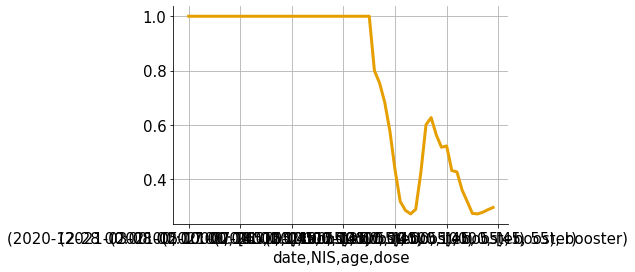

In [201]:
df_temppp = df_new.drop(columns=['INCIDENCE', 'CUMULATIVE'])
df_temppp = df_temppp.reset_index().set_index(['date', 'NIS', 'age', 'dose'])
df_temppp.loc[:,10000, pd.Interval(45,55,closed='left'), 'booster']['E_susc'].plot()

<AxesSubplot:xlabel='date,NIS,age,dose'>

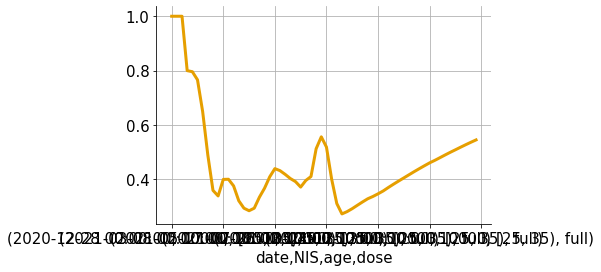

In [108]:
# df_new.loc[:, 10000, pd.Interval(25,35), 'full']

# df_new['E'].fillna(1, inplace=True)
df_new.groupby(['date', 'NIS', 'age', 'dose']).first().loc[:, 10000, pd.Interval(25,35,closed='left'), 'full']['E'].plot()

In [ ]:
df_new = df_new.groupby(['date', 'NIS', 'age', 'dose']).first()

df_new

In [ ]:

intervals = pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')
intervals_str = np.array(['[0, 12)', '[12, 18)', '[18, 25)', '[25, 35)', '[35, 45)', '[45, 55)', '[55, 65)', '[65, 75)', '[75, 85)', '[85, 120)'])
intervals_dict = dict({intervals_str[i] : intervals[i] for i in range(len(intervals))})
initN = initN.rename(columns=intervals_dict)

# initN_fulltable = initN.unstack().rename(column=dict({'age_class' : 'age'}))

df_new = pd.DataFrame(vacc_function.df).reset_index()
df_new = df_new.merge(initN.unstack().reset_index(), left_on=['NIS', 'age'], right_on=['NIS', 'age_class'])
df_new['fraction'] = df_new['0_x'] / df_new['0_y']
# df_new = df_new.drop(columns=['age_class', '0_x', '0_y'])
# df_new = df_new.set_index(['date', 'NIS', 'age', 'dose'])

# df_new.loc[:,:,:,'B']['fraction'] = df_new.loc[:,:,:,'A']['fraction'] - df_new.loc[:,:,:,'B']['fraction']
# df_new.loc[:,:,:,'A']['fraction']

df_new = df_new.set_index('date') # make sure we don't get NaN values because of mismatching indices
df_new_copy = df_new.copy()

# first-only: dose A (first) - dose B (second)
df_new.loc[df_new['dose']=='B','fraction'] = (df_new_copy.loc[df_new_copy['dose']=='A','fraction'] \
    - df_new_copy.loc[df_new_copy['dose']=='B','fraction']).clip(lower=0, upper=1)

# full: dose B (second) + dose C (Jansen) - dose E (booster)
df_new.loc[df_new['dose']=='C','fraction'] = (df_new_copy.loc[df_new_copy['dose']=='B','fraction'] \
    + df_new_copy.loc[df_new_copy['dose']=='C','fraction'] - df_new_copy.loc[df_new_copy['dose']=='E','fraction']).clip(lower=0, upper=1)

# booster: clip between 0 and 1. This is currently the latest stage
df_new.loc[df_new['dose']=='E','fraction'] = df_new_copy.loc[df_new_copy['dose']=='E', 'fraction'].clip(lower=0, upper=1)

# none. Rest category. Make sure all adds up to 1.
df_new.loc[df_new['dose']=='A','fraction'] = 1 - (df_new_copy.loc[df_new_copy['dose']=='B','fraction'] \
    - df_new_copy.loc[df_new_copy['dose']=='C','fraction'] - df_new_copy.loc[df_new_copy['dose']=='E','fraction']).clip(lower=0, upper=1)

# Return to multiindex
df_new = df_new.reset_index()
df_new = df_new.drop(columns=['age_class', '0_x', '0_y'])
df_new = df_new.set_index(['date','NIS', 'age', 'dose'])

# rename indices to clearly understandable categories
rename_indices = dict({'A' : 'none', 'B' : 'first', 'C' : 'full', 'E' : 'booster'})
df_new = df_new.rename(index=rename_indices)

# df_new_copy = df_new.copy()


In [ ]:
make_vaccination_function(vacc_data['CUMULATIVE']).df

In [ ]:
vacc_data.rename(index=dict({10000 : 'test'}))

                                                                                                                     
# initN

# initN.rename(columns=intervals_dict)

initN

In [ ]:
import datetime

df = pd.read_csv('../../data/raw/sciensano/COVID19BE_VACC_MUNI_raw.csv')

start=[]
end=[]
for year_week in df["YEAR_WEEK"].values:
    year = '20'+year_week[0:2]
    week = year_week[3:]
    if week == '53':
        week = str(int(year_week[3:])-1)

    startdate = "{}-{}-1".format(year, week)
    enddate = "{}-{}-6".format(year, week)

    dt = datetime.datetime.strptime(startdate, "%Y-%W-%w")
    start.append(dt.strftime("%Y-%m-%d"))

    dt = datetime.datetime.strptime(enddate, "%Y-%W-%w")
    end.append(dt.strftime("%Y-%m-%d"))
df['start_week'] = start
df['end_week'] = end

df

In [ ]:
######################
## Format dataframe ##
######################

df = df.drop(df[df.NIS5 == ''].index)
df = df.dropna()
df['CUMUL'][df['CUMUL'] == '<10'] = '0'
df['CUMUL'] = df['CUMUL'].astype(int)
df['NIS5'] = ((df['NIS5'].astype(float)).astype(int)).astype(str)
df = df.rename(columns={'NIS5':'NUTS5', 'AGEGROUP':'age'})
df.set_index('start_week')
df.pop('YEAR_WEEK')
df.pop('end_week')
df.set_index(['start_week','NUTS5','age','DOSE'], inplace=True)

In [ ]:
pd.concat?

In [ ]:
vacc_data